from https://dacon.io/competitions/official/235851

# 데이터 준비

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
WORKING_PATH = "/gdrive/MyDrive/colab/20220120_plant"

In [219]:
!mkdir -p {WORKING_PATH}

In [6]:
!apt-get install fastjar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fastjar
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 66.7 kB of archives.
After this operation, 175 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fastjar amd64 2:0.98-6build1 [66.7 kB]
Fetched 66.7 kB in 0s (171 kB/s)
Selecting previously unselected package fastjar.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../fastjar_2%3a0.98-6build1_amd64.deb ...
Unpacking fastjar (2:0.98-6build1) ...
Setting up fastjar (2:0.98-6build1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [7]:
!jar xvf {WORKING_PATH}/plant.zip

 inflated: open/sample_submission.csv
  created: open/test_dataset/
  created: open/test_dataset/BC/
  created: open/test_dataset/BC/1088/
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00010.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00030.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00036.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00072.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00076.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00097.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00099.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00103.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00111.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00115.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00120.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00134.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00161.png
 inflated: open/test_dataset/BC/1088/idx_BC_1088_00163.png
 inflated: open/test_dataset/BC/108

# 학습 데이터 파일 리스트

In [8]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [124]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
MAX_DELTA = 45
CLASS_NUM = MAX_DELTA

In [125]:
!pip install natsort

In [126]:
import os
import glob
import natsort 

data_root_path = './open/train_dataset/'
specieses = [ 'BC', 'LT' ]

path_2_filename = {}
for species in specieses:
    # species = 'BC'
    code_list = os.listdir(os.path.join(data_root_path, species))
    for code in code_list:
        file_list = os.listdir(os.path.join(data_root_path, species, code))
        file_list = natsort.natsorted(file_list)
        #                   'train_dataset', 'BC', 'BC_01'
        path = os.path.join(data_root_path, species, code)
        # path = 'train_dataset/BC/BC_01'
        # file_list = ['DAT07.png', 'DAT08.png', 'DAT33.png', ... ]
        path_2_filename[path] = file_list

all_count = 0
for path, filenames in path_2_filename.items():
    file_count = len(filenames)
    print(f"{path} : {file_count} images")
    all_count += file_count

print(f"all {all_count} images")

./open/train_dataset/BC/BC_04 : 43 images
./open/train_dataset/BC/BC_01 : 39 images
./open/train_dataset/BC/BC_05 : 40 images
./open/train_dataset/BC/BC_09 : 30 images
./open/train_dataset/BC/BC_03 : 41 images
./open/train_dataset/BC/BC_08 : 36 images
./open/train_dataset/BC/BC_02 : 40 images
./open/train_dataset/BC/BC_06 : 41 images
./open/train_dataset/BC/BC_07 : 43 images
./open/train_dataset/LT/LT_07 : 40 images
./open/train_dataset/LT/LT_06 : 39 images
./open/train_dataset/LT/LT_02 : 40 images
./open/train_dataset/LT/LT_01 : 40 images
./open/train_dataset/LT/LT_08 : 41 images
./open/train_dataset/LT/LT_10 : 40 images
./open/train_dataset/LT/LT_09 : 40 images
./open/train_dataset/LT/LT_05 : 40 images
./open/train_dataset/LT/LT_03 : 40 images
./open/train_dataset/LT/LT_04 : 40 images
all 753 images


# DataGenerator

In [131]:
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import RandomContrast


class DataGenerator(Sequence):

    def __init__(self, raw_data=None, base_set=None,
                 batch_size=BATCH_SIZE, 
                 shuffle=True,
                 validation_split=0.0,
                 test_split=0.0,
                 indexes=None,
                 max_size=None):
        self.raw_data = raw_data
        self.file_combinations = None
        self.shuffle = shuffle
        self.image_cache = {}
        self.batch_size = batch_size
        if base_set != None:
            self.raw_data = base_set.raw_data
            self.file_combinations = base_set.file_combinations
            self.image_cache = base_set.image_cache
            self.shuffle = base_set.shuffle
            self.batch_size = base_set.batch_size
            self.image_cache = base_set.image_cache

        self.indexes, self.valid_indexes, self.test_indexes = self._prepare_indexes(validation_split, test_split, indexes, max_size)
        self.data_augmentation = self._build_data_augmentation()

    def __len__(self):
        return int(len(self.indexes) / self.batch_size)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self._generate_data(indexes)

    def on_epoch_end(self):
        if self.shuffle == True:
            self._shuffle_index()

    def _build_data_augmentation(self):
        data_augmentation = tf.keras.Sequential([ 
                                                 RandomContrast((0.1, 0.1))
        ])
        return data_augmentation

    def _prepare_indexes(self, validation_split, test_split, indexes, max_size):
        if indexes is not None:
            return indexes, None, None

        def build_file_combinations():
            file_combinations = []
            path_2_filename = self.raw_data
            for code, file_list in path_2_filename.items():
                file_count = len(file_list)
                for i in range(file_count):
                    for j in range(i+1, file_count):
                        first_file_name = os.path.join(code, file_list[i])
                        second_file_name = os.path.join(code, file_list[j])
                        file_combinations.append((first_file_name, second_file_name))
            return file_combinations

        self.file_combinations = build_file_combinations()

        all_index = np.arange(len(self.file_combinations))
        np.random.shuffle(all_index)
        if max_size is not None:
            all_index = all_index[:max_size]

        if validation_split+test_split==0.0:
            return all_index, None, None

        valid_i = int(len(all_index)*(1-validation_split-test_split))
        test_i = int(len(all_index)*(1-test_split))

        return all_index[:valid_i], all_index[valid_i:test_i], all_index[test_i:]
        
    def _shuffle_index(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, file_name):
        if file_name in self.image_cache: return self.image_cache[file_name]
        image = plt.imread(file_name)
        resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
        resized = np.clip(resized, 0.0, 1.0)
        self.image_cache[file_name] = resized
        return resized

    def _day_delta(self, first_file_name, second_file_name):
        # "./open/train_dataset/BC/BC_02/DAT05.png"
        def extract_day(file_name):
            return int(file_name.split("/")[-1][3:5])
        return int(extract_day(second_file_name) - extract_day(first_file_name))


    def _generate_data(self, indexes):

        def augment(image):
            return self.data_augmentation(image)
            
        X1 = np.empty((len(indexes), IMAGE_SIZE, IMAGE_SIZE, 3))
        X2 = np.empty((len(indexes), IMAGE_SIZE, IMAGE_SIZE, 3))
        Y = np.empty((len(indexes), ))

        for i, index in enumerate(indexes):
            first_file_name, second_file_name = self.file_combinations[index]
            X1[i] = augment(self._load_image(first_file_name))
            X2[i] = augment(self._load_image(second_file_name))
            Y[i] = self._day_delta(first_file_name, second_file_name)
        return (X1, X2), np.array(Y).astype(np.int16)

    def get_all_data(self):
        return self._generate_data(self.indexes)        

    def subset(self, type):
        if type=="train":
            return DataGenerator(indexes=self.indexes, base_set=self)
        elif type=="validation" or type=="valid":
            return DataGenerator(indexes=self.valid_indexes, base_set=self)
        elif type=="test":
            return DataGenerator(indexes=self.test_indexes, base_set=self)
        else:
            print("invalid type {}".format(type))

    def _get_cache_file_name(self):
        return os.path.join(WORKING_PATH, "cache.npy")

    def preload(self):
        cache_file_name = self._get_cache_file_name()
        if os.path.isfile(cache_file_name):
            self.image_cache = np.load(cache_file_name, allow_pickle=True).item()
            print(f"image loaded from cache file {cache_file_name}. {len(self.image_cache)} images.")
            return
        step_count = self.__len__()
        for i in range(step_count):
            print(f"{i}/{step_count}")
            _, _ = self.__getitem__(i)
        np.save(cache_file_name, self.image_cache)
        print(f"image saved into cache file {cache_file_name}. {len(self.image_cache)} images.")


In [132]:
data_generator = DataGenerator(path_2_filename, validation_split=0.1, test_split=0.1)  

data_generator.preload()

train_data_generator = data_generator.subset("train")
valid_data_generator = data_generator.subset("valid")
test_data_generator = data_generator.subset("test")

print("train data size : ", len(train_data_generator.indexes))
print("valid data size : ", len(valid_data_generator.indexes))
print("test data size  : ", len(test_data_generator.indexes))

image loaded from cache file /gdrive/MyDrive/colab/20220120_plant/cache.npy. 753 images.
train data size :  11690
valid data size :  1461
test data size  :  1462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


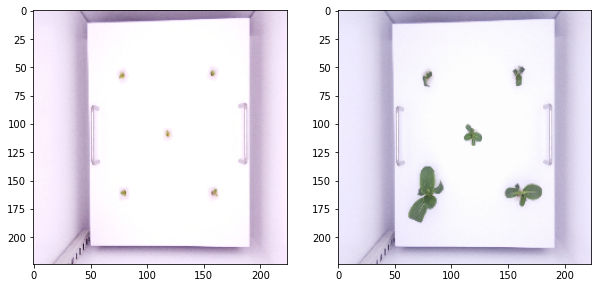

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


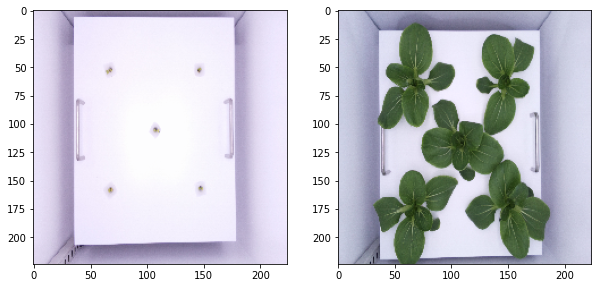

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


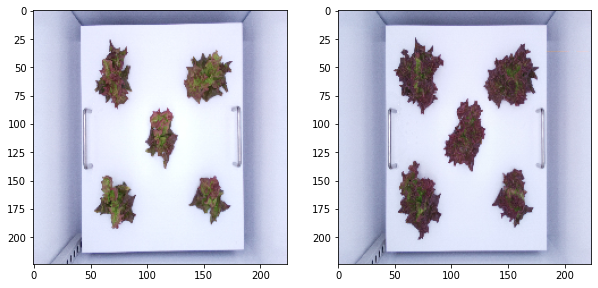

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


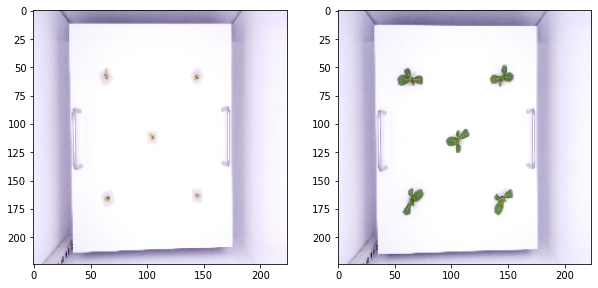

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


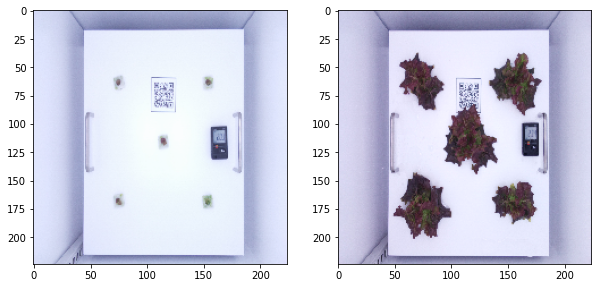

20


In [133]:
batch_x, batch_y = train_data_generator.__getitem__(0)

for i in range(5):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(batch_x[0][i])
    plt.subplot(1,2,2)
    plt.imshow(batch_x[1][i])
    plt.show()
    print(batch_y[i])

# 모델 학습

In [135]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Concatenate, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb2 (Functional)    (None, 7, 7, 1408)   7768569     ['input_23[0][0]',               
                                                                  'input_24[0][0]']         

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


365/365 [==============================] - 275s 696ms/step - loss: 3.7980 - acc: 0.0416 - val_loss: 3.8304 - val_acc: 0.0597
Epoch 2/100
365/365 [==============================] - ETA: 0s - loss: 3.5507 - acc: 0.0683
Epoch 00002: val_loss did not improve from 3.83041
365/365 [==============================] - 246s 673ms/step - loss: 3.5507 - acc: 0.0683 - val_loss: 3.8631 - val_acc: 0.0326
Epoch 3/100
365/365 [==============================] - ETA: 0s - loss: 3.3296 - acc: 0.0932
Epoch 00003: val_loss improved from 3.83041 to 3.74894, saving model to /gdrive/MyDrive/colab/20220120_plant/best_model.h5
365/365 [==============================] - 252s 690ms/step - loss: 3.3296 - acc: 0.0932 - val_loss: 3.7489 - val_acc: 0.0431
Epoch 4/100
365/365 [==============================] - ETA: 0s - loss: 3.1364 - acc: 0.1104
Epoch 00004: val_loss did not improve from 3.74894
365/365 [==============================] - 245s 671ms/step - loss: 3.1364 - acc: 0.1104 - val_loss: 3.7800 - val_acc: 0.0326

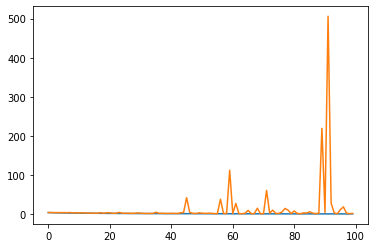

45/45 [==============================] - 13s 278ms/step - loss: 1.6497 - acc: 0.3819
loss= 1.649742603302002
acc= 0.3819444477558136


In [191]:
preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

input1 = Input((224,224,3))
input2 = Input((224,224,3))

conv_output1 = conv_layers(input1)
conv_output2 = conv_layers(input2)

conv_output1 = Flatten()(conv_output1)
conv_output2 = Flatten()(conv_output2)


x = Concatenate()([conv_output1, conv_output2])
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(CLASS_NUM, activation="softmax")(x)

model = Model([input1, input2], output)


from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001*0.1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()


from tensorflow.keras.callbacks import ModelCheckpoint
model_check_point = ModelCheckpoint(
    os.path.join(WORKING_PATH, 'best_model.h5'), 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=100,
      callbacks=[model_check_point]
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)


In [192]:
# model.save(os.path.join(WORKING_PATH, "model.h5"))

In [193]:
# model = keras.models.load_model(os.path.join(WORKING_PATH, "model.h5"))

In [194]:
loss, acc = model.evaluate(valid_data_generator)
print(loss)
print(acc)

45/45 [==============================] - 13s 282ms/step - loss: 1.6410 - acc: 0.4174
1.6409839391708374
0.4173611104488373


# test 데이터로 결과 확인

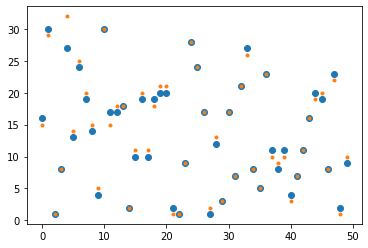

In [195]:
batch_x, batch_y = test_data_generator.get_all_data()
raw_predicted = model.predict(batch_x)
predicted = np.argmax(raw_predicted, axis=-1)

plt.plot(predicted[:50], "o")
plt.plot(batch_y[:50], '.')
plt.show()

# 테스트 데이터 만들기

In [198]:
test_root_path = os.path.join("open", "test_dataset")

In [199]:
test_df = pd.read_csv(os.path.join(test_root_path, "test_data.csv"))

In [200]:
test_df.head()

idx   before_file_path    after_file_path
0    0  idx_LT_1003_00341  idx_LT_1003_00154
1    1  idx_LT_1003_00592  idx_LT_1003_00687
2    2  idx_BC_1100_00445  idx_BC_1100_00840
3    3  idx_BC_1112_00229  idx_BC_1112_00105
4    4  idx_LT_1088_00681  idx_LT_1088_00698

In [201]:
count = len(test_df)
print(count)

3960


In [202]:
first_file_names = test_df.before_file_path.values
second_file_names = test_df.after_file_path.values

In [203]:
import os

def full_path(v):
    org_v = v
    v = v.replace("idx_", "")
    pathes = v.split("_")
    del pathes[-1]
    pathes.insert(0, test_root_path)
    pathes.append(f"{org_v}.png")
    path = os.path.join(*pathes)
    return path


In [204]:
first_full_path = [ full_path(v) for v in first_file_names ]
second_full_path = [ full_path(v) for v in second_file_names ]

In [205]:
print(first_full_path[0])
print(second_full_path[0])

open/test_dataset/LT/1003/idx_LT_1003_00341.png
open/test_dataset/LT/1003/idx_LT_1003_00154.png


In [206]:
import cv2

def load_image(file_name):
    image = plt.imread(file_name)
    resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    resized = np.clip(resized, 0.0, 1.0)
    return resized

def load_test_x(first_full_path, second_full_path):

    file_name = os.path.join(WORKING_PATH, "test_image.npy")
    test_x = tuple(np.load(file_name))
    print(f"test_x loaded from {file_name}.")
    return test_x

    first_images = []
    second_images = []
    for i in range(count):
        print(f"{i} / {count}")
        first_images.append(load_image(first_full_path[i]))
        second_images.append(load_image(second_full_path[i]))
    first_images = np.array(first_images)
    second_images = np.array(second_images)

    test_x = (first_images, second_images)
    
    np.save(file_name, test_x)
    print(f"test_x saved into {file_name}.")

    return test_x

test_x = load_test_x(first_full_path, second_full_path)

test_x loaded from /gdrive/MyDrive/colab/20220120_plant/test_image.npy.


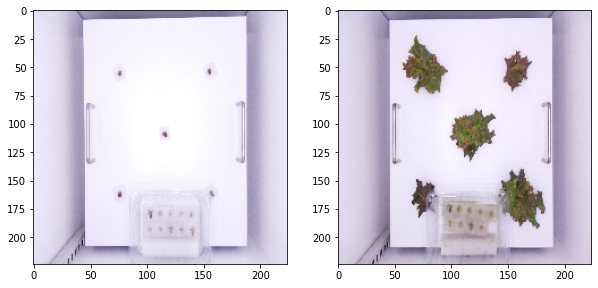

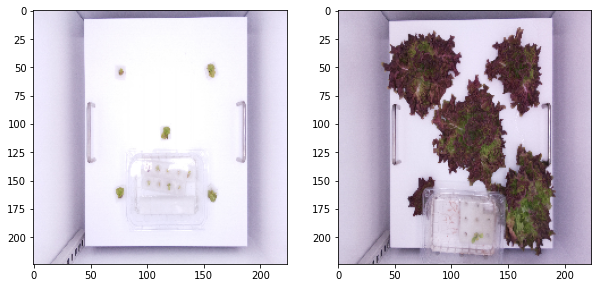

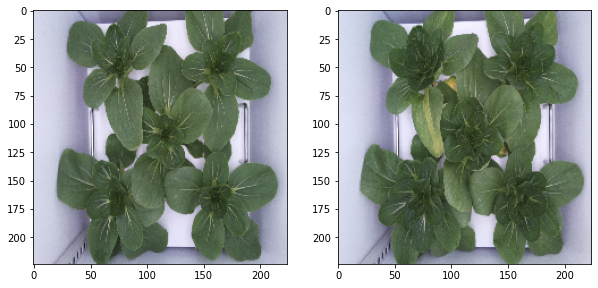

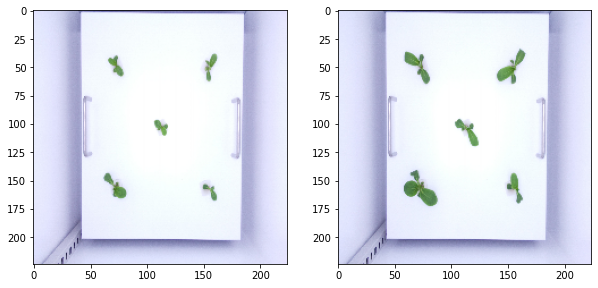

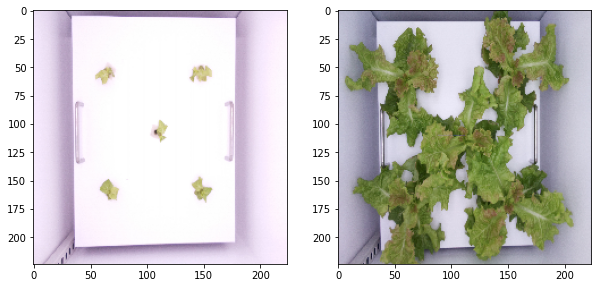

In [207]:
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_x[0][i])
    plt.subplot(1,2,2)
    plt.imshow(test_x[1][i])
    plt.show()

# 예측

In [208]:
raw_predicted = model.predict(test_x)
predicted = np.argmax(raw_predicted, axis=-1)

# 결과 파일 만들기

In [209]:
submission_df = pd.read_csv(os.path.join("open", "sample_submission.csv"))

In [210]:
submission_df.time_delta = predicted

In [211]:
submission_df.to_csv(os.path.join(WORKING_PATH, "submission.csv"), index=False)

In [212]:
!head {WORKING_PATH}/submission.csv

idx,time_delta
0,25
1,30
2,2
3,4
4,25
5,19
6,20
7,5
8,1


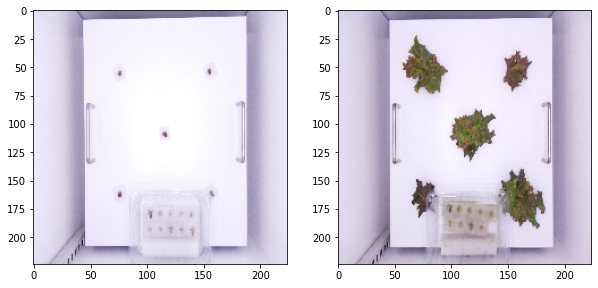

25


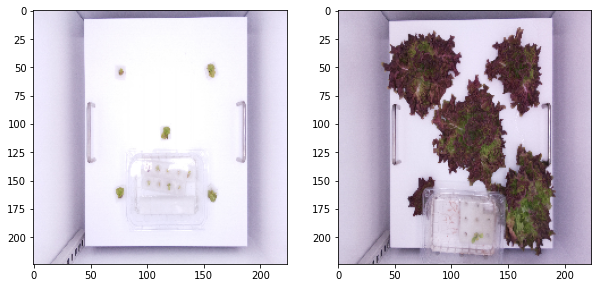

30


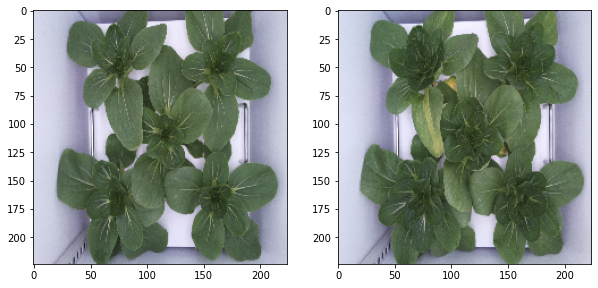

2


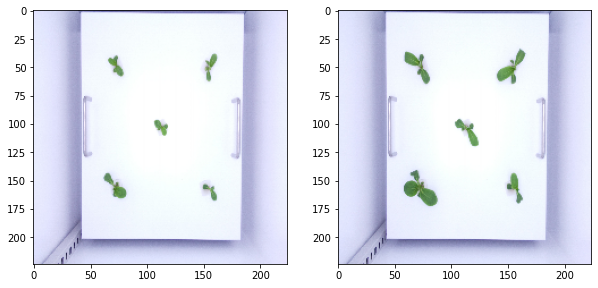

4


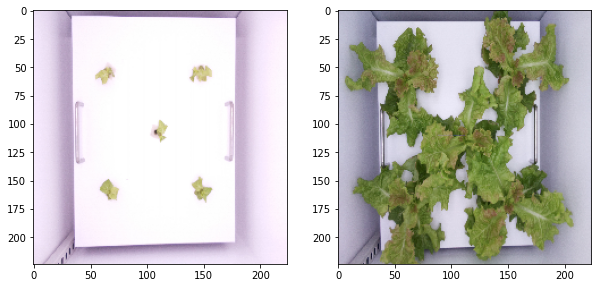

25


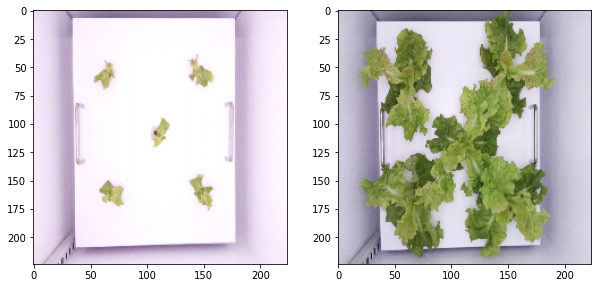

19


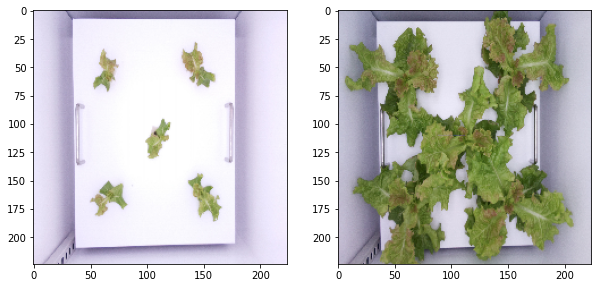

20


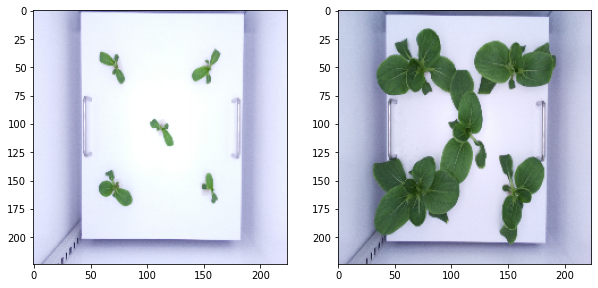

5


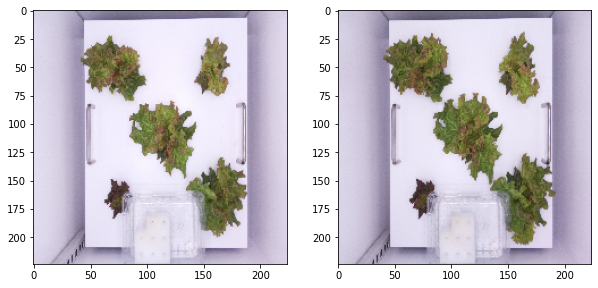

1


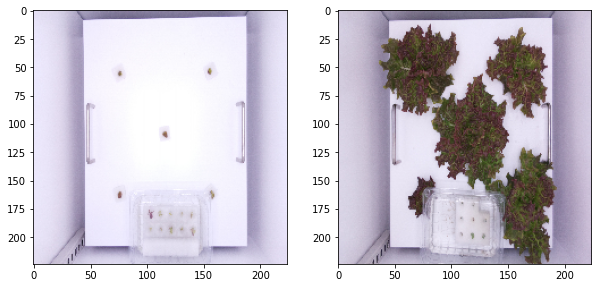

37


In [213]:
for i in range(10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_x[0][i])
    plt.subplot(1,2,2)
    plt.imshow(test_x[1][i])
    plt.show()
    print(predicted[i])